# 🦾 Modeling


In this notebook, we will create a simple baseline model and a more complex model to compare the performance of the two models. We will use the `NaiveBayes` model from the `scikit-learn` library as the simple model and the `XGBClassifier` model from the `xgboost` library as the complex model.

In [1]:
import os

for _ in range(3):
    if os.path.exists(f'{os.getcwd()}/setup.py'):
        break
    os.chdir('..')
print('Current working directory:', os.getcwd())

Current working directory: /Users/dewith/Repos/new-or-used


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder
from xgboost import XGBClassifier

from src.utils.config import get_dataset_path
from src.utils.styling import apply_styling, make_palette

In [3]:
# Seaborn
colors = make_palette()
palette = colors['palette']
apply_styling(colors)

# Pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

## Data Loading


Load the data into a pandas dataframe


In [4]:
df = pd.read_parquet(get_dataset_path('clean_items_train'))
print('Shape:', df.shape)

Shape: (90000, 95)


## Preprocessing Steps


Let's create the preprocessing steps for the models. The pipeline will consist of the following steps:
- Text preprocessing
- Category encoding
- Numerical scaling

In [5]:
target = 'condition'

In [6]:
# Prepare the data
X = df.drop(columns=[target])
y = df[target]

In [7]:
# Separate features by type
text_features = ['title_norm']
categorical_features = [
    col
    for col in df.columns
    if df[col].dtype == 'object' and col not in text_features + [target]
]
numerical_features = [
    col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != target
]

In [8]:
class CustomTFIDF(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf):
        self.tfidf = tfidf

    def fit(self, X, y=None):
        joined_X = X.apply(lambda x: ' '.join(x), axis=1)
        self.tfidf.fit(joined_X)
        return self

    def transform(self, X):
        joined_X = X.apply(lambda x: ' '.join(x), axis=1)
        return self.tfidf.transform(joined_X)

    def get_feature_names_out(self, input_features=None):
        return self.tfidf.get_feature_names_out(input_features)

In [9]:
# Create the preprocessors
vectorizer = Pipeline(
    steps=[
        (
            'tfidf',
            CustomTFIDF(TfidfVectorizer(ngram_range=(1, 2))),
        ),
    ]
)

cat_preprocessor = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ('target', TargetEncoder()),
    ]
)

num_preprocessor = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]
)

## Training and Evaluation

For training and evaluation, we will use:
1. A naive bayes model on the title text 
2. A random forest model on the numerical and categorical columns
3. A xgboost model on the title text, numerical and categorical columns

For evaluation, we will use a 5k cross validation with the following metrics:
- **Accuracy**
- **Precision**
- F1 Score
- Recall

#### On the second metric

When a user is looking for something in the marketplace, two bad things can happen:
- User is looking for a used product, the item is labeled as used but it's new (False Negative)
  - The user clicked on the item but didn't buy it because it was new (Bad)
- User is looking for a new product, the item is labeled as new but it's used (False Positive)
  - The user clicked on the item but didn't buy it because it was used (Bad)
  - The user didn't click on the item because it was labeled as used (Bad)
  - The user clicked on the item and bought it without knowing it was used (Worst)

We can clearly see that it's worse to have a False Positive than a False Negative.

Therefore, we'll use Precision (for the "new" class) as the second metric because this measures how many items predicted as new are actually new. It's crucial in our case because a low precision means many used items are being incorrectly labeled as new (false positives).

#### Naive Bayes (Level 0)


Training with a `Naive Bayes` model on the title data.


In [10]:
transformers = ColumnTransformer([('text', vectorizer, text_features)])
classifier = MultinomialNB()
pipeline = Pipeline(steps=[('features', transformers), ('classifier', classifier)])

In [11]:
# Perform cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
}
cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring, n_jobs=-1)

print('Cross-validation metrics:')
for metric, scores in cv_scores.items():
    if metric == 'fit_time' or metric == 'score_time':
        continue
    print(f'{metric:<16} {scores.mean():.4f} ± {scores.std():.4f}')

Cross-validation metrics:
test_accuracy    0.8036 ± 0.0025
test_precision   0.7890 ± 0.0041
test_recall      0.8661 ± 0.0025
test_f1_score    0.8257 ± 0.0017


### Random Forest (Level 1)


Trainig with a `Random Forest` model on tabular data.


In [12]:
transformers = ColumnTransformer(
    transformers=[
        ('cat', cat_preprocessor, categorical_features),
        ('num', num_preprocessor, numerical_features),
    ]
)
classifier = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
pipeline = Pipeline(steps=[('features', transformers), ('classifier', classifier)])

In [13]:
# Perform cross-validation
cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring, n_jobs=-1)

print('Cross-validation metrics:')
for metric, scores in cv_scores.items():
    if metric == 'fit_time' or metric == 'score_time':
        continue
    print(f'{metric:<16} {scores.mean():.4f} ± {scores.std():.4f}')

Cross-validation metrics:
test_accuracy    0.8568 ± 0.0012
test_precision   0.8793 ± 0.0015
test_recall      0.8502 ± 0.0033
test_f1_score    0.8645 ± 0.0014


#### Importances


In [14]:
pipeline = pipeline.fit(X, y)

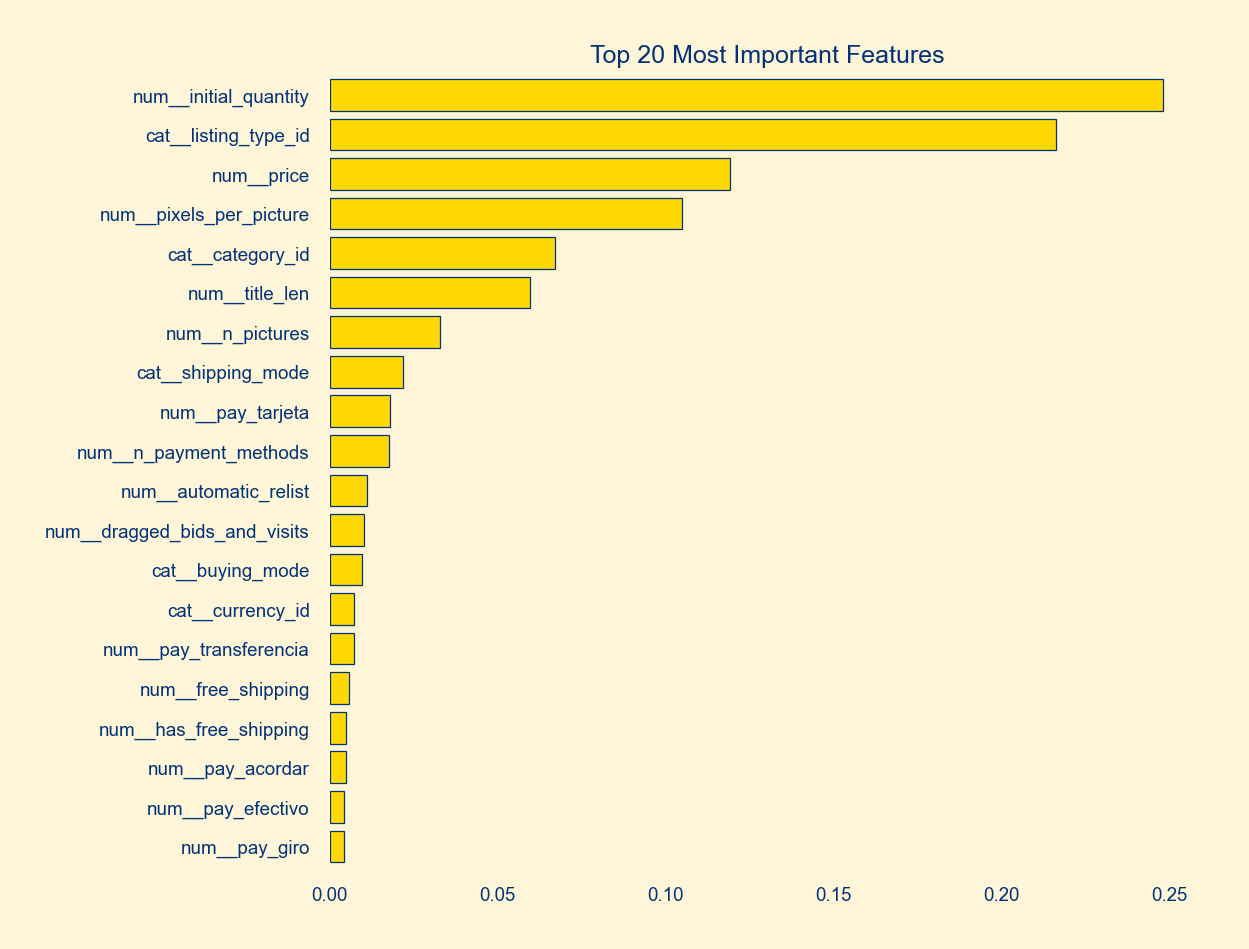

In [15]:
# Feature importance (for non-text features)
feature_importance = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['features'].get_feature_names_out()
importance_df = pd.DataFrame(
    {'feature': feature_names, 'importance': feature_importance}
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(
    y='feature',
    x='importance',
    data=importance_df.sort_values('importance', ascending=False).head(20),
    color=palette[0],
    edgecolor=colors['lines'],
    linewidth=0.6,
    alpha=1,
    saturation=1,
    ax=ax,
)
ax.set_title('Top 20 Most Important Features')
ax.set_ylabel('')
ax.set_xlabel('')
ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

### XGBoost (Level 2)


In [16]:
transformers = ColumnTransformer(
    transformers=[
        ('text', vectorizer, text_features),
        ('cat', cat_preprocessor, categorical_features),
        ('num', num_preprocessor, numerical_features),
    ]
)
classifier = XGBClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)
pipeline = Pipeline(steps=[('features', transformers), ('classifier', classifier)])

In [17]:
# Perform cross-validation
cv_scores = cross_validate(pipeline, X, y, cv=5, scoring=scoring, n_jobs=-1)

print('Cross-validation metrics:')
for metric, scores in cv_scores.items():
    if metric == 'fit_time' or metric == 'score_time':
        continue
    print(f'{metric:<16} {scores.mean():.4f} ± {scores.std():.4f}')

Cross-validation metrics:
test_accuracy    0.8801 ± 0.0023
test_precision   0.8990 ± 0.0026
test_recall      0.8752 ± 0.0045
test_f1_score    0.8869 ± 0.0023


#### Confusion Matrix

In [18]:
y_pred = cross_val_predict(pipeline, X, y, cv=5, n_jobs=-1)

In [24]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     41648
           1       0.90      0.88      0.89     48352

    accuracy                           0.88     90000
   macro avg       0.88      0.88      0.88     90000
weighted avg       0.88      0.88      0.88     90000



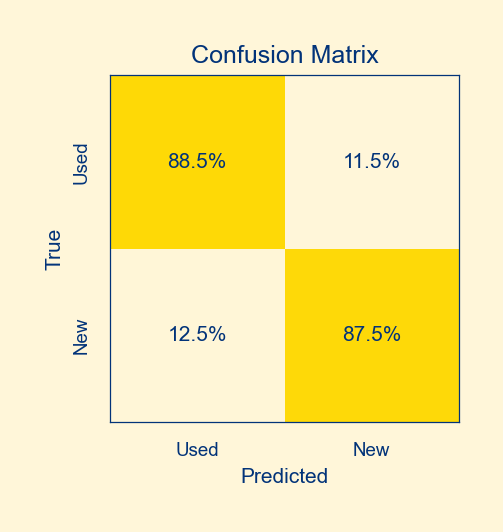

In [19]:
conf = confusion_matrix(y, y_pred, labels=[0, 1], normalize='true')

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
custom_cmap = LinearSegmentedColormap.from_list(
    'custom', [colors['background'], palette[0]]
)
sns.heatmap(
    conf,
    annot=True,
    fmt='.1%',
    cmap=custom_cmap,
    cbar=False,
    ax=ax,
    linewidths=0,
    linecolor=colors['lines'],
    annot_kws={
        'fontsize': 10,
        'color': colors['text_darker'],
        'alpha': 1,
        'verticalalignment': 'center',
    },
)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(['Used', 'New'])
ax.set_yticklabels(['Used', 'New'])
ax.spines[['left', 'bottom', 'right', 'top']].set_visible(True)
plt.show()

#### Importances


In [20]:
pipeline = pipeline.fit(X, y)

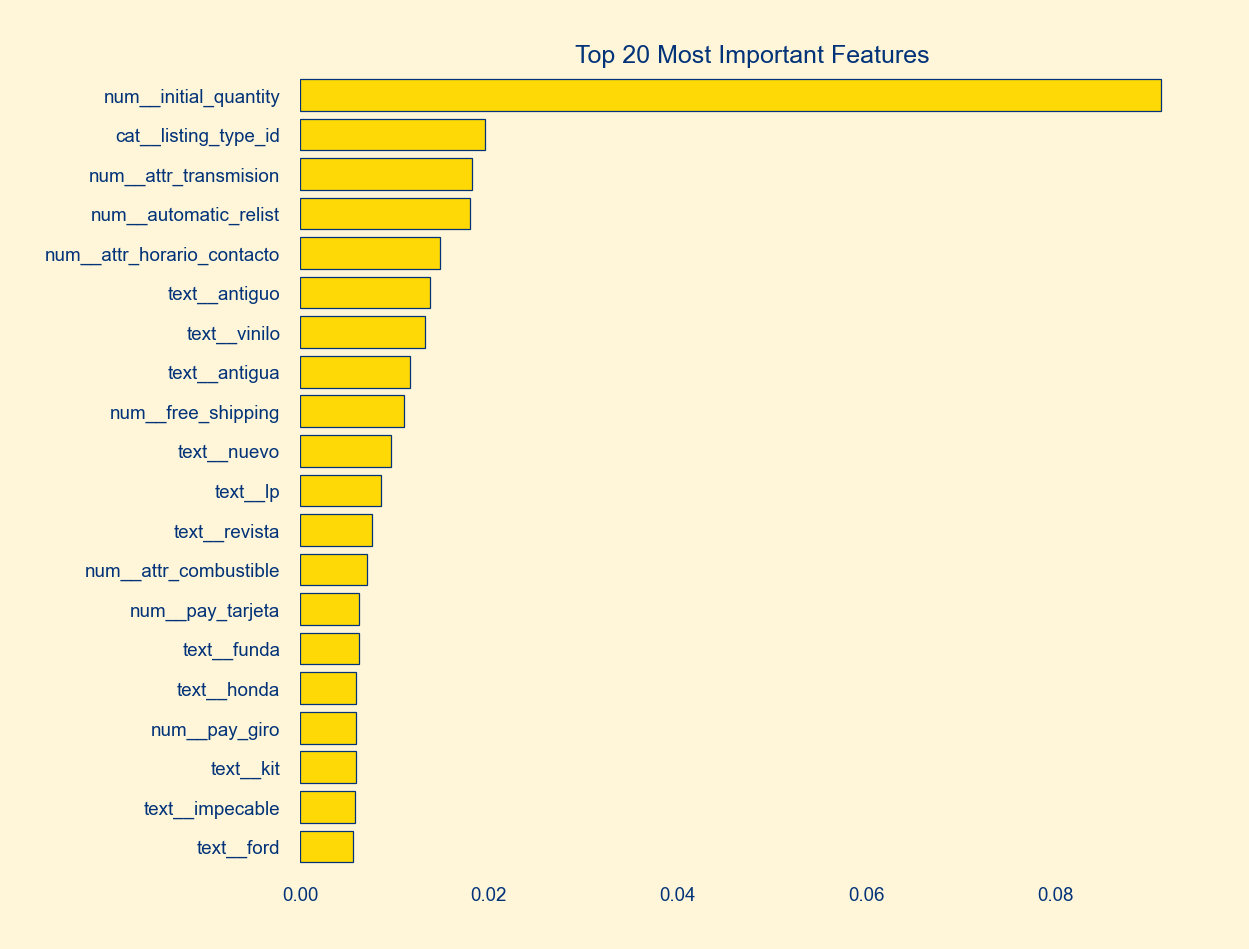

In [21]:
# Feature importance (for non-text features)
feature_importance = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['features'].get_feature_names_out()
importance_df = pd.DataFrame(
    {'feature': feature_names, 'importance': feature_importance}
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(
    y='feature',
    x='importance',
    data=importance_df.sort_values('importance', ascending=False).head(20),
    color=palette[0],
    edgecolor=colors['lines'],
    linewidth=0.6,
    alpha=1,
    saturation=1,
    ax=ax,
)
ax.set_title('Top 20 Most Important Features')
ax.set_ylabel('')
ax.set_xlabel('')
ax.spines[['left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()

Here's a summary of the key points:

- The most important feature by far is "initial_quantity", suggesting that the initial quantity being just 1 is a strong indicator of its condition (new or used).
- The "listing_type_id" is the second most important feature, indicating that the level (bronze, silver, etc) is also quite significant in determining an item's condition.
- Several flag features related to item attributes are important, such as "num__attr_transmision" (likely related to transmission in vehicles, as vehicles tend to be sold used), "num__automatic_relist" (if a itema is automatically relisted), and "num__attr_horario_contacto" (contact hours, more common in used items).
- There are several text-based features that seem important, including "text__antiguo" (old), "text__vinilo" (vinyl), "text__antigua" (ancient/old), and "text__nuevo" (new). These likely refer to words used in item title that are indicative of condition.
- "num__free_shipping" appears in the top 10, suggesting that shipping options may be correlated with an item's condition.
- Some features related to payment methods are present, such as "num__pay_tarjeta" (card payment) and "num__pay_giro" (bank transfer), though they are less important.
- Brand-related text features like "text__honda" and "text__ford" are present, indicating that certain brands might be associated with new or used items more frequently.
- The feature importances decrease gradually, with no sharp drops, suggesting that many features contribute to the model's predictions to varying degrees.

This analysis indicates that the model relies on a mix of quantitative (initial quantity, listing attributes) and qualitative (description text) features to make its predictions about whether an item is new or used. The initial quantity listed seems to be by far the most predictive feature for this classification task.

## Conclusion

The training can be summarized in the following table:

| Model         | Features                  | Accuracy  | Precision |
|---------------|---------------------------|-----------|-----------|
| Naive Bayes   | Title text                | 80.3%     | 78.9%     |
| Random Forest | Tabular data              | 85.7%     | 87.9%     |
| XGBoost       | Text and tabular data     | **88.0%** | **89.9%** |

The `XGBoost` model performed the best, with an accuracy of 88% and a precision of 90%. The model was able to predict the class of the items with a high accuracy and precision.

## Next Steps

Here are some ideas to further improve the model:
- Try to improve the models by tuning the hyperparameters and using a stacking method.
- Use how many items a seller has sold in the past as a feature.
- Use the item's description as a feature too, which is not present in the current data.
- Compute a new feature to indicate how far away is the price from the average price of the same category (or even the same produt), which could be a good indicator of the item's condition.
- Use better text preprocessing techniques, such as transformer-based embeddings or text classification using LLMs.